In [111]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error

import json
import pickle
import joblib

In [116]:
data = pd.read_csv('./feature_store/polynomial-features.csv', index_col=0)

In [117]:
data.head()

,last_weight,average_weight,size,start_weight last_weight,start_weight average_weight,last_weight^2,last_weight average_weight,last_weight fasting,last_weight morning_temperature,last_weight evening_temperature,...,morning_temperature size,evening_temperature size,morning_do size,evening_do size,morning_salinity size,morning_pH size,transparency size,long_cycle size,size^2,average_adg
0,25.18,14.428,63.750000,131.6914,75.45844,634.0324,363.29704,25.18,705.04,755.4,...,1785.0,1912.500000,316.8375,359.550000,1466.250000,503.625000,2422.500000,7140.0,4064.062500,0.270
1,26.59,15.167,64.000000,131.6205,75.07665,707.0281,403.29053,26.59,744.52,797.7,...,1792.0,1920.000000,318.0800,360.960000,1472.000000,505.600000,2432.000000,7744.0,4096.000000,0.267
2,16.25,10.725,89.000000,85.3125,56.30625,264.0625,174.28125,16.25,455.00,487.5,...,2492.0,2670.000000,442.3300,501.960000,2047.000000,703.100000,3382.000000,8366.0,7921.000000,0.281
3,15.70,11.035,109.200000,84.7800,59.58900,246.4900,173.24950,15.70,439.60,471.0,...,3057.6,3276.000000,542.7240,615.888000,2511.600000,862.680000,4149.600000,10264.8,11924.640000,0.273
4,24.76,13.033,70.857143,68.5852,36.10141,613.0576,322.69708,24.76,693.28,742.8,...,1984.0,2125.714286,352.1600,399.634286,1629.714286,559.771429,2692.571429,8432.0,5020.734694,0.256


In [119]:
for key in data.keys():
    print(key)

last_weight
average_weight
size
start_weight last_weight
start_weight average_weight
last_weight^2
last_weight average_weight
last_weight fasting
last_weight morning_temperature
last_weight evening_temperature
last_weight morning_do
last_weight evening_do
last_weight morning_salinity
last_weight morning_pH
last_weight transparency
last_weight long_cycle
average_weight^2
average_weight fasting
average_weight morning_temperature
average_weight evening_temperature
average_weight morning_do
average_weight evening_do
average_weight morning_salinity
average_weight morning_pH
average_weight transparency
average_weight long_cycle
fasting size
morning_temperature size
evening_temperature size
morning_do size
evening_do size
morning_salinity size
morning_pH size
transparency size
long_cycle size
size^2
average_adg


In [146]:
# Normalization function
def min_max_normalize(df):
    min_vals = df.min()
    max_vals = df.max()
    normalized_df = (df - min_vals) / (max_vals - min_vals)
    return normalized_df, min_vals, max_vals

# Apply normalization
normalized_df, min_vals, max_vals = min_max_normalize(data)


In [150]:
max_vals

last_weight                           8.500000e+01
average_weight                        8.500000e+01
size                                  1.352728e+03
start_weight last_weight              7.225000e+03
start_weight average_weight           7.225000e+03
last_weight^2                         7.225000e+03
last_weight average_weight            7.225000e+03
last_weight fasting                   4.754000e+01
last_weight morning_temperature       2.422279e+03
last_weight evening_temperature       2.547443e+03
last_weight morning_do                4.224500e+02
last_weight evening_do                4.794000e+02
last_weight morning_salinity          1.955000e+03
last_weight morning_pH                6.832740e+02
last_weight transparency              3.230000e+03
last_weight long_cycle                9.350000e+03
average_weight^2                      7.225000e+03
average_weight fasting                3.030000e+01
average_weight morning_temperature    2.422279e+03
average_weight evening_temperat

In [121]:
# Save normalized data and min/max values
normalized_df.to_csv('normalized_data.csv', index=False)
min_max_values = {'min': min_vals.to_dict(), 'max': max_vals.to_dict()}
with open('min_max_values.json', 'w') as f:
    json.dump(min_max_values, f)

print("Normalization complete and min/max values saved.")


Normalization complete and min/max values saved.


In [122]:
X = normalized_df.drop(columns=['average_adg']).values
y = normalized_df['average_adg'].values

In [123]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)


In [124]:
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

In [125]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

input_dim = X.shape[1]  # Jumlah fitur
hidden_dim = 64  # Ukuran layer tersembunyi
output_dim = 1  # Output tunggal (num_of_harvest)

model = MLP(input_dim, hidden_dim, output_dim)

In [126]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [127]:
def train_model(model, criterion, optimizer, X_train, y_train, num_epochs=100):
    for epoch in range(num_epochs):
        model.train()
        
        optimizer.zero_grad()
        
        outputs = model(X_train)
        
        loss = criterion(outputs, y_train)
        
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    return model

In [128]:
model = train_model(model, criterion, optimizer, X_train, y_train, num_epochs=1000)

Epoch [10/1000], Loss: 0.0617
Epoch [20/1000], Loss: 0.0131
Epoch [30/1000], Loss: 0.0051
Epoch [40/1000], Loss: 0.0060
Epoch [50/1000], Loss: 0.0041
Epoch [60/1000], Loss: 0.0038
Epoch [70/1000], Loss: 0.0036
Epoch [80/1000], Loss: 0.0033
Epoch [90/1000], Loss: 0.0031
Epoch [100/1000], Loss: 0.0030
Epoch [110/1000], Loss: 0.0029
Epoch [120/1000], Loss: 0.0028
Epoch [130/1000], Loss: 0.0027
Epoch [140/1000], Loss: 0.0026
Epoch [150/1000], Loss: 0.0026
Epoch [160/1000], Loss: 0.0025
Epoch [170/1000], Loss: 0.0024
Epoch [180/1000], Loss: 0.0024
Epoch [190/1000], Loss: 0.0023
Epoch [200/1000], Loss: 0.0022
Epoch [210/1000], Loss: 0.0022
Epoch [220/1000], Loss: 0.0021
Epoch [230/1000], Loss: 0.0021
Epoch [240/1000], Loss: 0.0021
Epoch [250/1000], Loss: 0.0021
Epoch [260/1000], Loss: 0.0021
Epoch [270/1000], Loss: 0.0020
Epoch [280/1000], Loss: 0.0020
Epoch [290/1000], Loss: 0.0020
Epoch [300/1000], Loss: 0.0020
Epoch [310/1000], Loss: 0.0020
Epoch [320/1000], Loss: 0.0020
Epoch [330/1000],

In [135]:
model

MLP(
  (fc1): Linear(in_features=36, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [136]:
with torch.no_grad():
    prediction_normalized = model(X_test)
    y_pred = prediction_normalized.numpy()

In [133]:
y_pred[:10]

array([[0.20587347],
       [0.16363315],
       [0.21287464],
       [0.2220067 ],
       [0.2215399 ],
       [0.14856824],
       [0.2762003 ],
       [0.18201634],
       [0.2250245 ],
       [0.17771158]], dtype=float32)

In [134]:
y_test[:10]

tensor([[0.1828],
        [0.1697],
        [0.2221],
        [0.1440],
        [0.1571],
        [0.1898],
        [0.2910],
        [0.1623],
        [0.2339],
        [0.0982]])

# Denormalization

In [137]:
def denorm(data, min_, max_):
    return data* (max_ - min_) + min_

In [138]:
with open('min_max_values.json', 'rb') as file:
    min_max = json.load(file)

In [139]:
y_test_real = denorm(y_test, min_max['min']['average_adg'], min_max['max']['average_adg'])

In [140]:
y_test_real[:10]

tensor([[1.9400e-01],
        [1.6400e-01],
        [2.8400e-01],
        [1.0500e-01],
        [1.3500e-01],
        [2.1000e-01],
        [4.4200e-01],
        [1.4700e-01],
        [3.1100e-01],
        [1.4901e-08]])

In [141]:
y_pred_real = denorm(y_pred, min_max['min']['average_adg'], min_max['max']['average_adg'])

In [142]:
y_pred_real[:10]

array([[0.24686202],
       [0.15004721],
       [0.2629087 ],
       [0.28383937],
       [0.28276947],
       [0.11551842],
       [0.4080511 ],
       [0.19218147],
       [0.2907562 ],
       [0.18231496]], dtype=float32)

In [151]:

torch.save(model.state_dict(), 'base_model.pth')

In [143]:

# Simpan model menggunakan pickle
with open('base_model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [61]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

In [62]:
class PyTorchRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, input_dim, hidden_dim=50, output_dim=1, lr=0.001, num_epochs=100, optimizer_type='adam'):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lr = lr
        self.num_epochs = num_epochs
        self.optimizer_type = optimizer_type
        self.model = None
        self.criterion = nn.MSELoss()
        self.optimizer = None
    
    def _get_optimizer(self, model):
        if self.optimizer_type == 'adam':
            return optim.Adam(model.parameters(), lr=self.lr)
        elif self.optimizer_type == 'sgd':
            return optim.SGD(model.parameters(), lr=self.lr)
        elif self.optimizer_type == 'rmsprop':
            return optim.RMSprop(model.parameters(), lr=self.lr)
        elif self.optimizer_type == 'adagrad':
            return optim.Adagrad(model.parameters(), lr=self.lr)
        elif self.optimizer_type == 'adadelta':
            return optim.Adamax(model.parameters(), lr=self.lr)
        elif self.optimizer_type == 'adamax':
            return optim.NAdam(model.parameters(), lr=self.lr)
        elif self.optimizer_type == 'nadam':
            return optim.RMSprop(model.parameters(), lr=self.lr)
        else:
            raise ValueError(f"Unsupported optimizer type: {self.optimizer_type}")
    
    def fit(self, X, y):
        self.model = MLP(self.input_dim, self.hidden_dim, self.output_dim)
        self.optimizer = self._get_optimizer(self.model)
        
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)
        
        self.model = train_model(self.model, self.criterion, self.optimizer, X_tensor, y_tensor, self.num_epochs)
        return self
    
    def predict(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            predictions = self.model(X_tensor).numpy()
        return predictions
    
    def score(self, X, y):
        y_pred = self.predict(X)
        y_true = y
        return -((y_pred - y_true) ** 2).mean()

In [63]:
param_grid = {
    'hidden_dim': [8, 16, 32],
    'lr': [0.001, 0.01, 0.1],
    'num_epochs': [100, 200, 500],
    'optimizer_type': ['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam']
}

In [64]:
scorer = make_scorer(lambda y_true, y_pred: -((y_pred - y_true) ** 2).mean())
regressor = PyTorchRegressor(input_dim=input_dim)
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, scoring=scorer, cv=3)

In [65]:
grid_search.fit(X_train.numpy(), y_train.numpy())

Epoch [10/100], Loss: 0.0061
Epoch [20/100], Loss: 0.0018
Epoch [30/100], Loss: 0.0021
Epoch [40/100], Loss: 0.0017
Epoch [50/100], Loss: 0.0016
Epoch [60/100], Loss: 0.0016
Epoch [70/100], Loss: 0.0015
Epoch [80/100], Loss: 0.0015
Epoch [90/100], Loss: 0.0015
Epoch [100/100], Loss: 0.0015
Epoch [10/100], Loss: 0.2407
Epoch [20/100], Loss: 0.1774
Epoch [30/100], Loss: 0.1198
Epoch [40/100], Loss: 0.0736
Epoch [50/100], Loss: 0.0415
Epoch [60/100], Loss: 0.0226
Epoch [70/100], Loss: 0.0138
Epoch [80/100], Loss: 0.0109
Epoch [90/100], Loss: 0.0102
Epoch [100/100], Loss: 0.0099
Epoch [10/100], Loss: 0.1264
Epoch [20/100], Loss: 0.1094
Epoch [30/100], Loss: 0.0930
Epoch [40/100], Loss: 0.0755
Epoch [50/100], Loss: 0.0577
Epoch [60/100], Loss: 0.0411
Epoch [70/100], Loss: 0.0271
Epoch [80/100], Loss: 0.0169
Epoch [90/100], Loss: 0.0107
Epoch [100/100], Loss: 0.0079
Epoch [10/100], Loss: 0.0052
Epoch [20/100], Loss: 0.0051
Epoch [30/100], Loss: 0.0051
Epoch [40/100], Loss: 0.0051
Epoch [50/1

GridSearchCV(cv=3, estimator=PyTorchRegressor(input_dim=37),
             param_grid={'hidden_dim': [8, 16, 32], 'lr': [0.001, 0.01, 0.1],
                         'num_epochs': [100, 200, 500],
                         'optimizer_type': ['adam', 'sgd', 'rmsprop', 'adagrad',
                                            'adadelta', 'adamax', 'nadam']},
             scoring=make_scorer(<lambda>, response_method='predict'))

In [66]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [67]:
print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

Best parameters: {'hidden_dim': 16, 'lr': 0.01, 'num_epochs': 500, 'optimizer_type': 'adam'}
Best score: -0.001867138179174314


In [68]:
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test.numpy())

In [69]:
mae, rmse = calculate_metrics(y_test.numpy(), y_test_pred)
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

MAE: 0.0230
RMSE: 0.0332


In [74]:
import joblib

joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']

In [75]:
import pickle

In [76]:

# Simpan model menggunakan pickle
with open('best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

In [70]:
import matplotlib.pyplot as plt

In [71]:
def plot_regression_results(y_true, y_pred):
    
    # Plot predicted vs true values
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_pred, edgecolor='k', alpha=0.7)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted')

    # Plot the residuals/errors
    residuals = y_true - y_pred
    plt.subplot(1, 2, 2)
    plt.scatter(y_pred, residuals, edgecolor='k', alpha=0.7)
    plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='r', linestyles='dashed')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted')

    plt.tight_layout()
    plt.show()


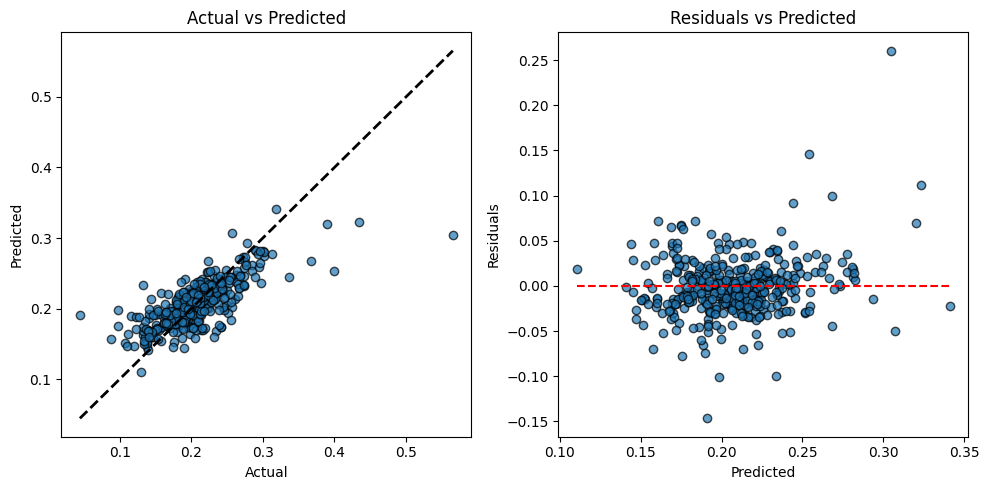

In [72]:
plot_regression_results(y_test.numpy(), y_test_pred)